Object `attrgot` not found.


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
from fastai.vision import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '079c978071fc4b018cbc369ff9b8fe02')

In [5]:
results = search_images_bing(key, 'trump', 'biden', max_images=150)

In [6]:
ims = results.attrgot('contentUrl')

In [7]:
len(ims)
ims

(#150) ['https://nationalinterest.org/sites/default/files/main_images/RTS2UO2L_0.jpg','https://d.newsweek.com/en/full/1018157/donald-trump-smile.jpg','https://d.newsweek.com/en/full/1573813/us-president-donald-trump.jpg','https://idsb.tmgrup.com.tr/ly/uploads/images/2021/01/08/thumbs/800x531/84628.jpg?v=1610122384','https://d.newsweek.com/en/full/1362332/donald-trump-getty-images.jpg','https://images.saymedia-content.com/.image/MTcxODc3NzAxMjUzMDgwMzg2/president-donald-trump-sad.jpg','https://d.newsweek.com/en/full/1788048/donald-trump-facebook-twitter-google.jpg','https://cbsnews1.cbsistatic.com/hub/i/2015/07/07/c22e8f87-2d9b-43ab-98d6-30caa9cc5906/gettyimages-113257835.jpg','https://d.newsweek.com/en/full/1688634/donald-trump.jpg','https://d.newsweek.com/en/full/343432/donald-trump.jpg'...]

In [8]:
dest = 'images/president.jpg'
download_url(ims[0], dest)

Path('images/president.jpg')

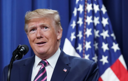

In [9]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [10]:
president_types = 'biden', 'trump'
path = Path('president')

In [11]:
if not path.exists(): 
    path.mkdir()
    for o in president_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{o} president')
        download_images(dest, urls = results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#255) [Path('president/biden/ef7e4763-cd0c-408d-9ac0-261a7883456d.jpg'),Path('president/biden/741a53e3-e829-41e7-b2fc-7c1dcd7702cf.jpg'),Path('president/biden/ea3faabd-b3c9-4785-8786-add54b7c4f78.jpg'),Path('president/biden/bc8ee785-54cb-434f-ab73-f4fd71af2eff.jpg'),Path('president/biden/d52070b7-3128-4a00-b61d-fb1b1bfb5b84.jpg'),Path('president/biden/ad1a946a-d30b-48ba-bc31-5ebd02eae8f6.jpg'),Path('president/biden/4ffdc267-cd78-4b8f-bbc0-f6fab35bc4b8.jpg'),Path('president/biden/096d82e9-f5ce-4579-b346-0effcaf27a4b.jpg'),Path('president/biden/880d185d-f8ae-4217-9fb6-70376411f713.jpg'),Path('president/biden/fc6066ae-8f83-40e0-9581-e281b444e942.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink);

In [15]:
presidents = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(120))

In [16]:
dls = presidents.dataloaders(path)

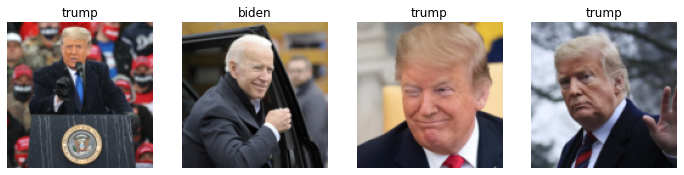

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

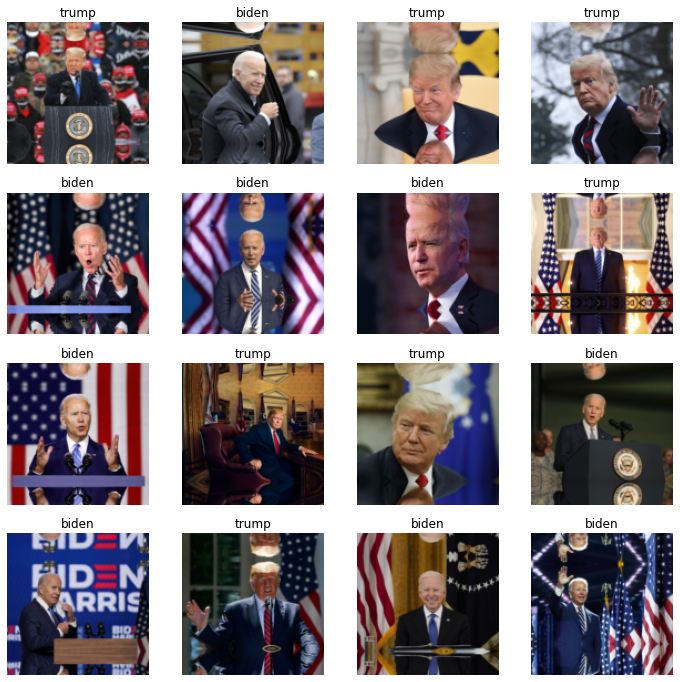

In [21]:
presidents = presidents.new(item_tfms=Resize(128, ResizeMethod.Pad))
dls = presidents.dataloaders(path)
dls.valid.show_batch(max_n=16, nrows = 4)

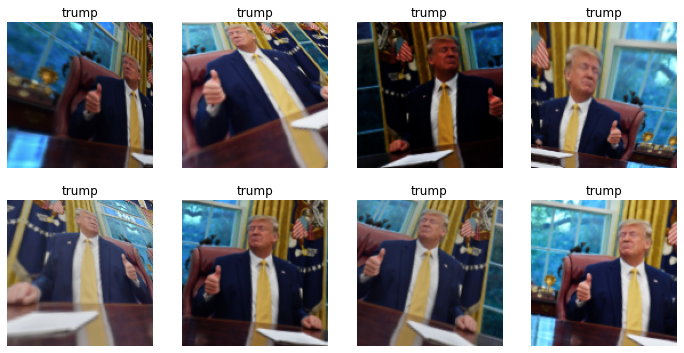

In [22]:
presidents = presidents.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = presidents.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [24]:
presidents = presidents.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = presidents.dataloaders(path)

In [28]:
learn=vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.344281,0.834927,0.470588,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.811868,0.740202,0.352941,00:13
1,0.870636,0.603607,0.313725,00:12
2,0.847101,0.513431,0.294118,00:12
3,0.824160,0.479876,0.235294,00:12
4,0.816235,0.402514,0.156863,00:13
5,0.760962,0.365321,0.156863,00:12
6,0.723408,0.306687,0.196078,00:13
7,0.679413,0.292266,0.098039,00:13
8,0.632560,0.282184,0.117647,00:13
9,0.618985,0.282427,0.117647,00:12


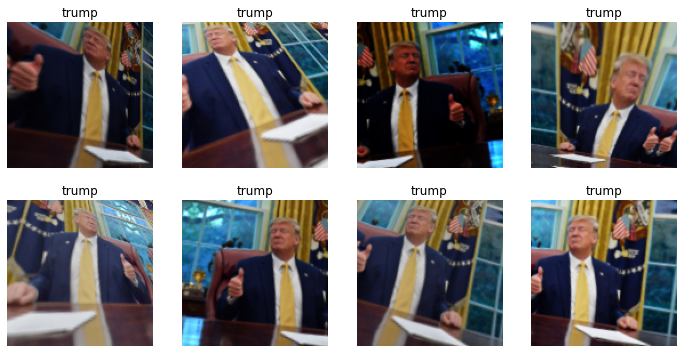

In [25]:
presidents = presidents.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = presidents.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

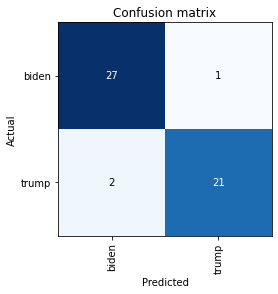

In [124]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

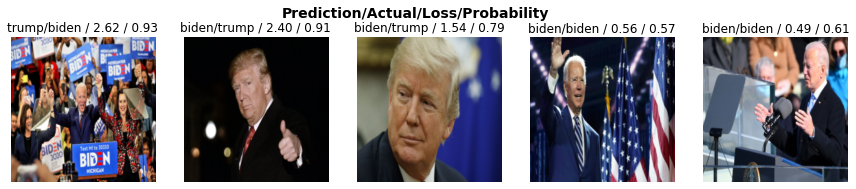

In [125]:
interp.plot_top_losses(5, nrows=1)

In [118]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [119]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/president.jpg')

('trump', TensorBase(1), TensorBase([0.0236, 0.9764]))

In [34]:
learn_inf.dls.vocab

['biden', 'trump']

In [35]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [52]:
img = PILImage.create(btn_upload.data[-1])

In [53]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [54]:
pred,pred_idx,probs = learn_inf.predict(img)

In [55]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction {pred}; Probability: {probs[pred_idx]: 04f}'
lbl_pred

Label(value='Prediction trump; Probability:  0.572158')

In [44]:
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [49]:
def on_click_classify(change):
    img = PILImage.create(btn_upload_data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
    btn_run.on_click(on_click_classify)
                                        

In [50]:
btn_upload = widgets.FileUpload()

In [51]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [57]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /root/mambaforge/etc/jupyter
    - Validating...
      voila 0.3.5 OK
